In [44]:
%%capture
%matplotlib inline
import numpy as np
import pickle
import tools

In [45]:
num_spaces = 3
num_prices = 3
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
pi = np.ones((num_spaces + 1, num_prices)) / num_prices

In [46]:
V

array([0., 0., 0., 0.])

In [47]:
state = 0
V[state]

np.float64(0.0)

In [48]:
state = 0
value = 10
V[state] = value
V

array([10.,  0.,  0.,  0.])

In [49]:
for s, v in enumerate(V):
    print(f'State {s} has value {v}')

State 0 has value 10.0
State 1 has value 0.0
State 2 has value 0.0
State 3 has value 0.0


In [50]:
pi

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [51]:
state = 0
pi[state]

array([0.33333333, 0.33333333, 0.33333333])

In [52]:
state = 0
action = 1
pi[state, action]

np.float64(0.3333333333333333)

In [53]:
pi[state] = np.array([0.75, 0.21, 0.04])
pi

array([[0.75      , 0.21      , 0.04      ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [54]:
# for i in range (len(pi)):
#     for j in range(len(pi[i])):
#         print(f'pi(A={j}|S={i}) = {pi[i][j].round(2)}' + '    ', end='')
#     print()

In [55]:
for s, pi_s in enumerate(pi):
    print(f''.join(f'pi(A={a}|S={s}) = {p.round(2)}' + 4 * ' ' for a, p in enumerate(pi_s)))

pi(A=0|S=0) = 0.75    pi(A=1|S=0) = 0.21    pi(A=2|S=0) = 0.04    
pi(A=0|S=1) = 0.33    pi(A=1|S=1) = 0.33    pi(A=2|S=1) = 0.33    
pi(A=0|S=2) = 0.33    pi(A=1|S=2) = 0.33    pi(A=2|S=2) = 0.33    
pi(A=0|S=3) = 0.33    pi(A=1|S=3) = 0.33    pi(A=2|S=3) = 0.33    


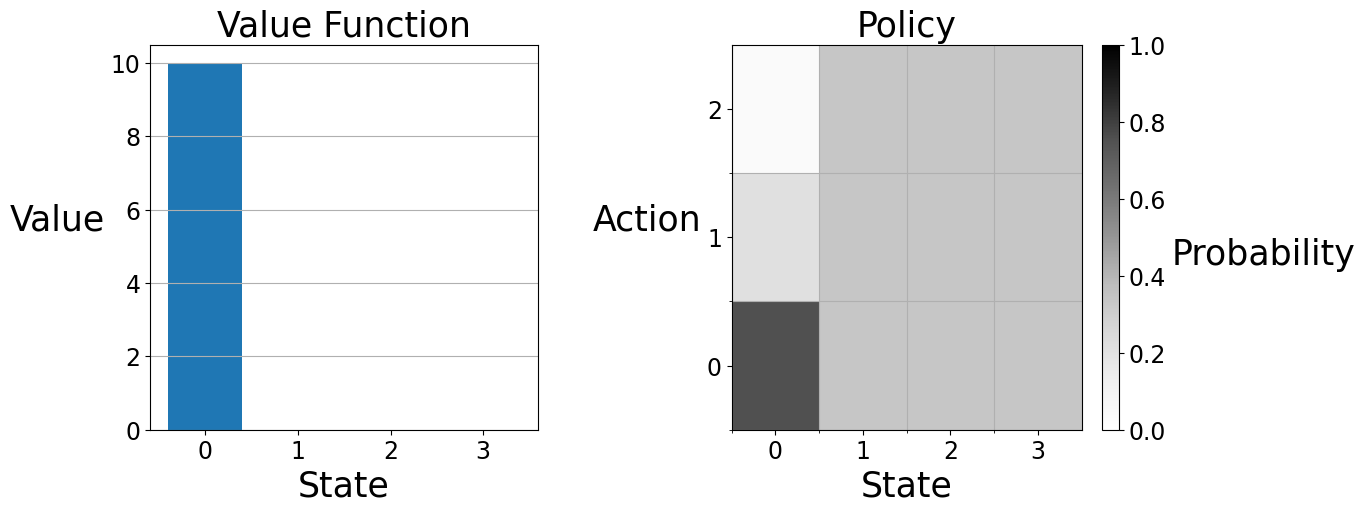

In [56]:
tools.plot(V, pi)

In [57]:
env.S

[0, 1, 2, 3]

In [58]:
env.A

[0, 1, 2]

In [59]:
state = 3
action = 1
transitions = env.transitions(state, action)
transitions

array([[1.        , 0.12390437],
       [2.        , 0.15133714],
       [3.        , 0.1848436 ],
       [2.        , 0.53991488]])

In [60]:
# for i in range(len(transitions)):
#     r, p = transitions[i][0], transitions[i][1]
#     print(f'p(S\'={i}, R={r} | S={state}, A={action}) = {p.round(2)}')  

In [61]:
for s_, (r, p) in enumerate(transitions):
    print(f'p(S\'={s_}, R={r} | S={state}, A={action}) = {p.round(2)}')

p(S'=0, R=1.0 | S=3, A=1) = 0.12
p(S'=1, R=2.0 | S=3, A=1) = 0.15
p(S'=2, R=3.0 | S=3, A=1) = 0.18
p(S'=3, R=2.0 | S=3, A=1) = 0.54


In [65]:
def evaluate_policy(env, V, pi, gamma, theta):
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V

In [66]:
def bellman_update(env, V, pi, s, gamma):
    v = 0
    for action in env.A:
        action_prob = pi[s][action]
        transitions = env.transitions(s, action)
        for next_state in env.S:
            reward = transitions[next_state, 0]
            prob = transitions[next_state, 1]
            v += action_prob * prob * (reward + gamma * V[next_state])
    V[s] = v        

In [68]:
num_spaces = 10
num_prices = 4
env = tools.ParkingWorld(num_spaces, num_prices)
V = np.zeros(num_spaces + 1)
city_policy = np.zeros((num_spaces + 1, num_prices))

# for i in range(len(city_policy)):
#     city_policy[i][1] = 1
city_policy[:, 1] = 1

gamma = 0.9
theta = 0.1
V = evaluate_policy(env, V, city_policy, gamma, theta)

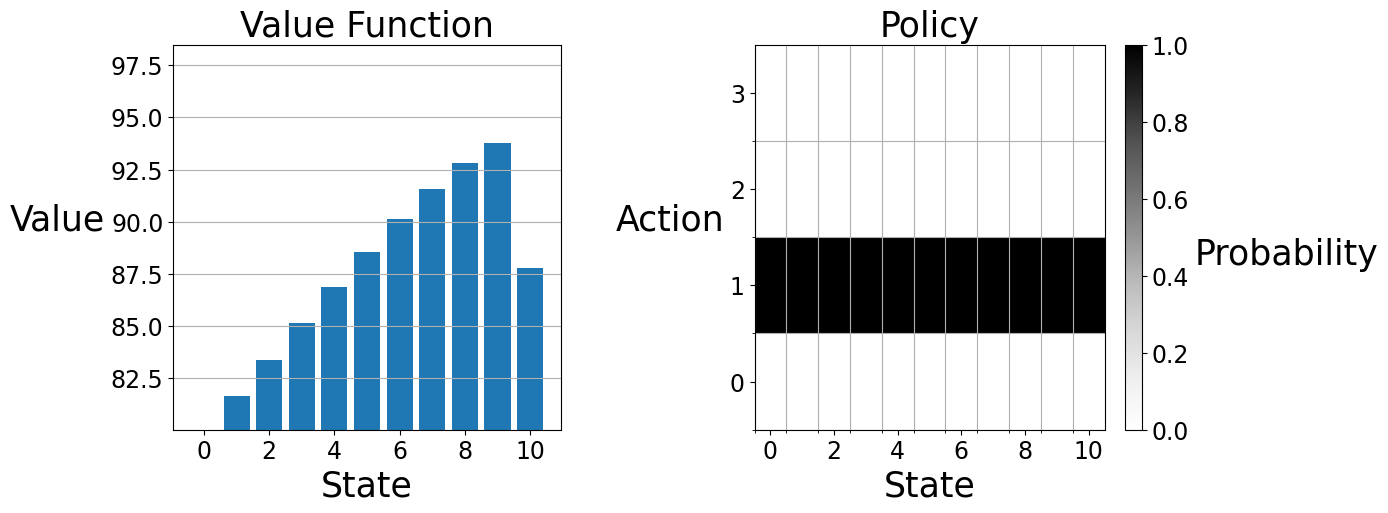

In [69]:
tools.plot(V, city_policy)

In [71]:
## Test Code for bellman_update() ## 
with open('section1', 'rb') as handle:
    V_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)

In [72]:
def policy_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, pi, gamma, theta)
        pi, policy_stable = improve_policy(env, V, pi, gamma)
    return V, pi

In [73]:
def improve_policy(env, V, pi, gamma):
    policy_stable = True
    for s in env.S:
        old = pi[s].copy()
        q_greedify_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old):
            policy_stable = False
    return pi, policy_stable

In [74]:
def q_greedify_policy(env, V, pi, s, gamma):
    A = np.zeros(len(env.A))
    for action in env.A:
        transitions = env.transitions(s, action)
        for next_state in env.S:
            reward = transitions[next_state, 0]
            prob = transitions[next_state, 1]
            A[action] += prob * (reward + gamma * V[next_state])
    best_action = np.argmax(A)
    pi[s] = np.eye(len(env.A))[best_action]

In [75]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = policy_iteration(env, gamma, theta)

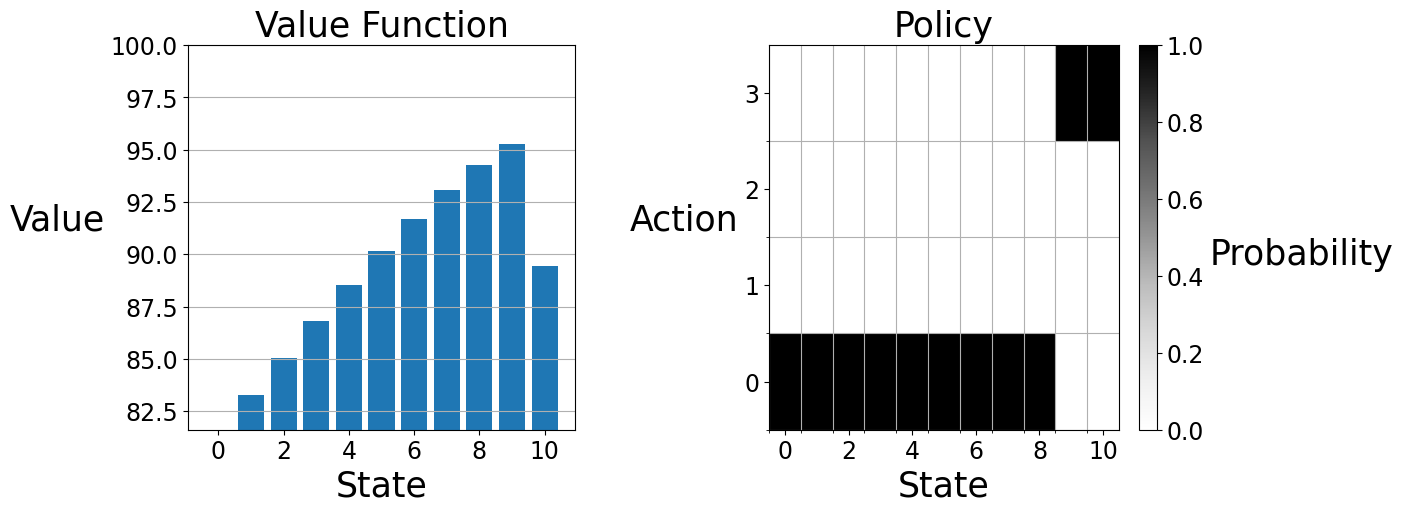

In [76]:
tools.plot(V, pi)

In [77]:
## Test Code for q_greedify_policy() ##
with open('section2', 'rb') as handle:
    V_correct, pi_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)
np.testing.assert_array_almost_equal(pi, pi_correct)

In [78]:
def value_iteration(env, gamma, theta):
    V = np.zeros(len(env.S))
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_optimality_update(env, V, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    for s in env.S:
        q_greedify_policy(env, V, pi, s, gamma)
    return V, pi

In [80]:
def bellman_optimality_update(env, V, s, gamma):
    v = np.zeros(len(env.A))
    for action in env.A:
        transitions = env.transitions(s, action)
        for next_state in env.S:
            reward = transitions[next_state, 0]
            prob = transitions[next_state, 1]
            v[action] += prob * (reward + gamma * V[next_state])
    V[s] = np.max(v)

In [81]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration(env, gamma, theta)

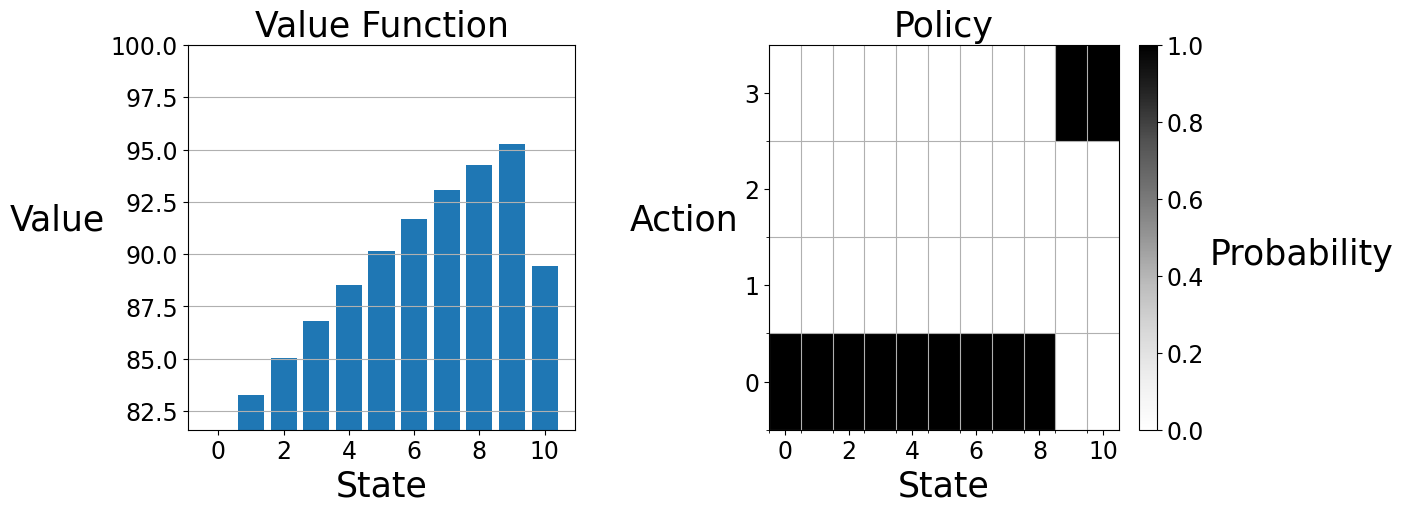

In [82]:
tools.plot(V, pi)

In [83]:
## Test Code for bellman_optimality_update() ## 
with open('section3', 'rb') as handle:
    V_correct, pi_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)
np.testing.assert_array_almost_equal(pi, pi_correct)

In [84]:
def value_iteration2(env, gamma, theta):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    while True:
        delta = 0
        for s in env.S:
            v = V[s]
            q_greedify_policy(env, V, pi, s, gamma)
            bellman_update(env, V, pi, s, gamma)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V, pi

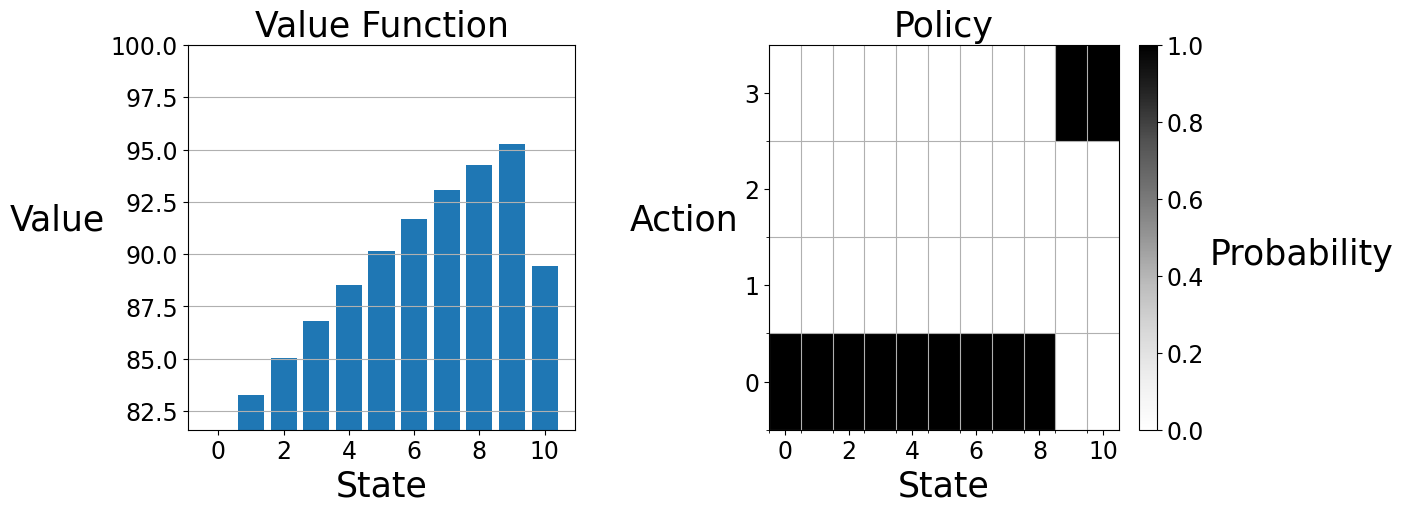

In [85]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
theta = 0.1
V, pi = value_iteration2(env, gamma, theta)
tools.plot(V, pi)

In [86]:
def real_time_dynamic_programming(env, gamma, horizon):
    V = np.zeros(len(env.S))
    pi = np.ones((len(env.S), len(env.A))) / len(env.A)
    s = env.random_state()
    for t in range(horizon):
        real_time_dynamic_programming_helper(env, V, pi, s, gamma)
        a = np.random.choice(env.A, p=pi[s])
        s = env.step(s, a)
    return V, pi

In [87]:
def real_time_dynamic_programming_helper(env, V, pi, s, gamma):
    q_greedify_policy(env, V, pi, s, gamma)
    bellman_optimality_update(env, V, s, gamma)

In [88]:
env = tools.ParkingWorld(num_spaces=10, num_prices=4)
gamma = 0.9
horizon = 500
np.random.seed(101)
V, pi = real_time_dynamic_programming(env, gamma, horizon)

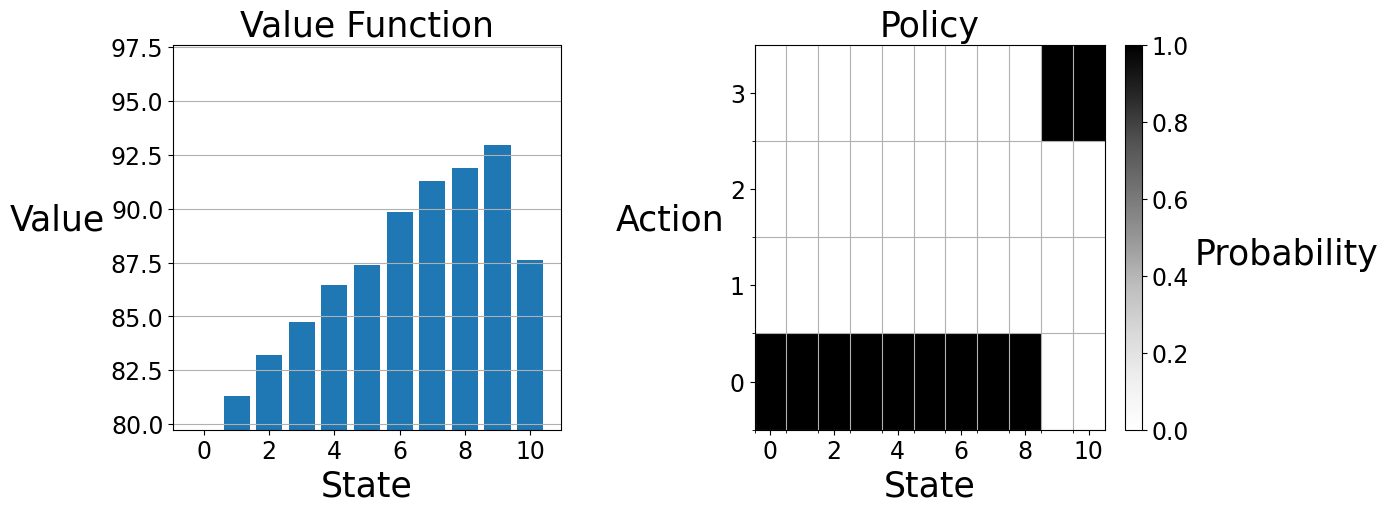

In [89]:
tools.plot(V, pi)

In [91]:
## Test Code for real_time_dynamic_programming_helper() ## 
with open('section4', 'rb') as handle:
    V_correct, pi_correct = pickle.load(handle)
np.testing.assert_array_almost_equal(V, V_correct)
np.testing.assert_array_almost_equal(pi, pi_correct)